<a href="https://colab.research.google.com/github/Lucas01iveira/data_science-alura/blob/master/Curso-ModelosDeNLP/Spark_ProcessamentoLinguagemNatural.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Sessão e leitura dos dados**

In [ ]:
# Instalando o PySpark
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 7.5 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=70e6254aaf4a0e02b70ebeaf60c59029a69b8244d94c1be26bb045c8bbb21fe2
  Stored in directory: /root/.cache/pip/wheels/b1/59/a0/a1a0624b5e865fd389919c1a10f53aec9b12195d6747710baf
Successfully built pyspark


In [ ]:
# Iniciando uma sessão
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("analise_nlp") \
    .getOrCreate()

spark

In [ ]:
from google.colab import drive
drive.mount('my-drive')

Mounted at my-drive


In [ ]:
# baixando o kaggle: https://www.kaggle.com/datasets/luisfredgs/imdb-ptbr
# Leitura dos dados:
# 1. Pela conexão com o google drive #2. Pelo carregamento no colab.(<---)
dados = spark.read.csv("/content/my-drive/MyDrive/Colab_Notebooks/Alura-CursoSparkNLP/imdb-reviews-pt-br.csv",
                       escape="\"",
                       header=True,
                       inferSchema=True)

# o parâmetro 'escape' serve para indicar que nossos dados estão indicados com aspas
# (a ideia é incluir para evitar maiores problemas)

dados.show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
| 11|Cage plays a drun...|Cage interpreta u...|      neg|
| 12|First of all, I w...|Primeiro de tudo,...|      neg|
| 13|So tell me - what...|Então me diga - q...|      neg|
| 14|A big disappointm...|Uma grande decepç...|      neg|
| 15|This film

### **Explorando os dados**



In [ ]:
# verificando o tamanho do nosso dataset
print('Quantidade de linhas: {}'.format(dados.count()))
print('Quantidade de colunas: {}'.format(len(dados.columns)))

Quantidade de linhas: 49459
Quantidade de colunas: 4


In [ ]:
# verificando a configuração de datatypes
dados.printSchema()

#dados.dtypes

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [ ]:
# verificando as primeiras 5 linhas 

dados.limit(5).show()
#dados.show(5)

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
+---+--------------------+--------------------+---------+



In [ ]:
# select de um comentário negativo
print('comentário negativo: ')
dados.select('text_pt').filter(dados.id == 190).show(truncate=False)

comentário negativo: 
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                    

In [ ]:
# select de um comentário positivo
print('comentário positivo: ')
dados.select('text_pt').filter(dados['id'] == 12427).show(truncate=False)

comentário positivo: 
+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text_pt                                                                                                                                                                                                                                                  

In [ ]:
# faço uma avaliação da quantidade de comentários positivos/negativos distribuídos no dataset
dados\
  .groupBy('sentiment')\
  .count()\
  .show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [ ]:
# Pode-se notar que há um equilíbrio de registros na nossa base 
# (quantidade +/- igual entre comentários positivos e negativos)

## Limpeza e processamento dos dados

- A primeira etapa do estudo consiste em limpar os nossos dados:
  - Remover caracteres especiais e espaços em branco (no início e no final)
    - Logo após a remoção de caracteres especiais é necessário realizar o processo de tokenização, que consiste em dividir uma frase em palavras (tokens) individuais

  - Remover stop words (preposições / pronomes / verbos), que não carregam tanto sentido para os fins do nosso estudo
  - Normalizar os registros (obter um padrão a partir das palavras incluídas)

- Construindo uma nuvem de palavras para reconhecimento dos registros

In [ ]:
# relembrando como está a nossa base
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



In [ ]:
# A nuvem de palavras é um recurso muito bom para verificar quais são as palavras mais frequentes

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# defino uma amostra apenas para verificar o funcionamento do recurso
amostra = dados.select('text_pt').sample(fraction = 0.1, seed = 101)

# parâmetros do sample
  # - fraction: fração de dados
  # - seed: semente de aleatoriedade

In [ ]:
# agora começamos definindo uma lista com todas as informações da amostra gerada

tudo = [ texto.text_pt for texto in amostra.collect() ]

# A cláusula '.collect()' do dataframe spark retorna todas as linhas do dataframe, que nós estamos chamando de texto
# Uma vez obtida essa linha, seus parâmetros / atributos podem ser acessados como linha.col_name ou linha['col_name']

# Então, o que a sequência acima está fazendo é: 
  # definindo uma lista em que cada elemento representa o dado contido em "text_pt" da linha 'texto',
  # que está sendo iterada sobre todas as linhas do dataframe (geradas a partir do método collect)

In [ ]:
wordcloud = WordCloud(
              collocations = False,
              background_color = 'white',
              prefer_horizontal = True,
              width = 1000,
              height = 600
              )\
              .generate(str(tudo))

# parâmetro "collocations" incluído para gerar apenas palavras individuais na imagem
# parâmetro "prefer_horizontal" incluído para que as palavras fiquem todas na horizontal
# parâmetro "background_color" é apenas cosmético, bem como width e height

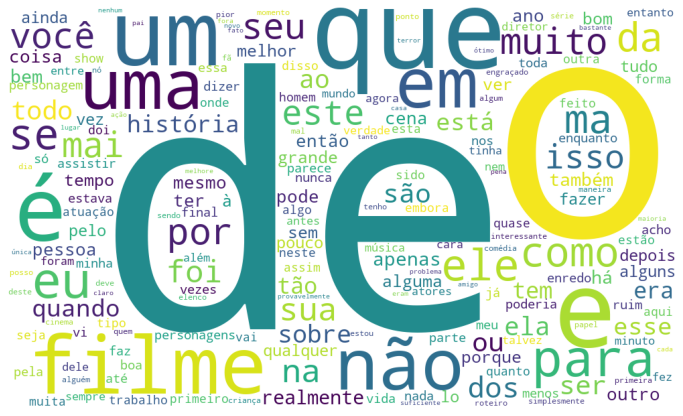

In [ ]:
ax = plt.figure(figsize=(12,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

- **Limpeza:** caracteres especiais

In [ ]:
# comecemos removendo caracteres especiais
import string
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# os símbolos anteriores são alguns dos caracteres que queremos remover
# para entender o funcionamento das funções que temos interesse em aplicar, 
# consideremos a seguinte amostra de dados

amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",),
        ], ["textos"])

amostra.show(truncate=False)

+------------------------------------------+
|textos                                    |
+------------------------------------------+
|Oi, JP! Blz?                              |
|$$$\ |~ Parabéns ~| \$$$                  |
|(#amovc #paz&amor ^.^)                    |
|"bora *_* "                               |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-|
|{comprar: arroz; feijão e pepino} //      |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |
|ana@gmail.com                             |
+------------------------------------------+



In [ ]:
# faço o import da biblioteca de functions do pyspark
from pyspark.sql import functions as f 

amostra = amostra.withColumn('texto_regexp', f.regexp_replace(amostra.textos, '[!"#\$%&\'()*+,-./:;<=>?@\[\]^_`´{|}~\\\\]', '') )
#amostra = amostra.withColumn('texto_regexp', f.regexp_replace(amostra.textos, "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", '') )

#amostra = amostra.withColumn("text_regex", f.regexp_replace("textos", "\$", ""))
# alguns caracteres têm funcionalidade dentro do próprio texto dependendo do contexto em estudo;
# esses caracteres devem ser precedidos pora uma contra-barra \ (regra de sintaxe)

# lembrando que nas situações em que o regexp precisar tratar mais de um caracter/padrão, estes deverão ser passados
# entre colchetes

# para identificar contra-barras ao longo do texto corrido que estamos analisando, é necessário
# incluir 4 contra-barras no campo de busca do regexp.

amostra.show(truncate=False)

+------------------------------------------+------------------------------+
|textos                                    |texto_regexp                  |
+------------------------------------------+------------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |
|"bora *_* "                               |bora                          |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |                              |
|ana@gmail.com                             |anagmailcom                   |
+------------------------------------------+------------------------------+



In [ ]:
# ainda falta remover os espaços em branco sem significado
amostra = amostra.withColumn('texto_tratado', f.trim( f.col('texto_regexp') ) )
amostra.show(truncate=False)

+------------------------------------------+------------------------------+-----------------------------+
|textos                                    |texto_regexp                  |texto_tratado                |
+------------------------------------------+------------------------------+-----------------------------+
|Oi, JP! Blz?                              |Oi JP Blz                     |Oi JP Blz                    |
|$$$\ |~ Parabéns ~| \$$$                  |  Parabéns                    |Parabéns                     |
|(#amovc #paz&amor ^.^)                    |amovc pazamor                 |amovc pazamor                |
|"bora *_* "                               |bora                          |bora                         |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-| vc foi selecionad            |vc foi selecionad            |
|{comprar: arroz; feijão e pepino} //      |comprar arroz feijão e pepino |comprar arroz feijão e pepino|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |  

In [ ]:
# agora que já sabemos como essas funções de tratamento do spark funcionam, vamos aplicar ao nosso conjunto de dados
# ps.: para desenvolver esse estudo focaremos na coluna em inglês

dados = dados.withColumn('texto_limpo', f.trim( f.regexp_replace( f.col('text_en'), '[!"#\$%&\'()*+,-./:;<=>?@\[\]^_`´{|}~\\\\]', '' ) ) )

## **Tokenização:** divisão em tokens

In [ ]:
# importando a biblioteca de trabalho
from pyspark.ml.feature import Tokenizer

# defino o objeto tokenizer
tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol='tokens')

# aplico a transformação nos nossos dados
dataset_tokenizado = tokenizer.transform(dados)

In [ ]:
dataset_tokenizado.select('texto_limpo', 'tokens').show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [ ]:
# Verificando em quantos tokens os comentários foram divididos
# Para isso defino uma função udf (udf - user defined function) simples
from pyspark.sql.types import IntegerType

countTokens = f.udf(lambda x: len(x), IntegerType())
# ou seja: countTokens é uma função que recebe como parâmetro uma lista 
# (podendo ser aplicado aos dataframes spark, que é a nossa intenção) e retorna
# como resultado o len dessa lista, do tipo inteiro

dataset_tokenizado\
  .select('texto_limpo', 'tokens')\
  .withColumn('qtd_tokens', countTokens(f.col('tokens')))\
  .show()

+--------------------+--------------------+----------+
|         texto_limpo|              tokens|qtd_tokens|
+--------------------+--------------------+----------+
|Once again Mr Cos...|[once, again, mr,...|       168|
|This is an exampl...|[this, is, an, ex...|       232|
|First of all I ha...|[first, of, all, ...|       215|
|Not even the Beat...|[not, even, the, ...|       308|
|Brass pictures mo...|[brass, pictures,...|       238|
|A funny thing hap...|[a, funny, thing,...|       115|
|This German horro...|[this, german, ho...|       156|
|Being a longtime ...|[being, a, longti...|       136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|       129|
|Wealthy horse ran...|[wealthy, horse, ...|       160|
|Cage plays a drun...|[cage, plays, a, ...|       109|
|First of all I wo...|[first, of, all, ...|       333|
|So tell me  what ...|[so, tell, me, , ...|       243|
|A big disappointm...|[a, big, disappoi...|       110|
|This film is abso...|[this, film, is, ...|       185|
|Heres a d

- Função [RegexTokenizer](https://spark.apache.org/docs/3.1.3/api/python/reference/api/pyspark.ml.feature.RegexTokenizer.html)
  - É possível efetuar os tratamentos de regexp e de tokenização simultaneamente com o auxílio dessa única função. 

In [ ]:
amostra = spark.createDataFrame([
                ("Oi, JP! Blz?",),
                ("$$$\\ |~ Parabéns ~| \\$$$",),
                ("(#amovc #paz&amor ^.^)",),
                ("\"bora *_* \"",),
                ("=>->'...``` vc foi selecionad@ ´´´...'<=<-",),
                ("{comprar: arroz; feijão e pepino} //",),
                ("!\"#$&'()*+,-./:;<=>?@[\]^_`{|}~",),
                ("ana@gmail.com",),
        ], ["textos"])

amostra.show(truncate=False)

+------------------------------------------+
|textos                                    |
+------------------------------------------+
|Oi, JP! Blz?                              |
|$$$\ |~ Parabéns ~| \$$$                  |
|(#amovc #paz&amor ^.^)                    |
|"bora *_* "                               |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-|
|{comprar: arroz; feijão e pepino} //      |
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |
|ana@gmail.com                             |
+------------------------------------------+



In [ ]:
from pyspark.ml.feature import RegexTokenizer

# definição do objeto de tratamento
reTokenizer = RegexTokenizer(
    inputCol = 'textos',
    outputCol = 'tokens',
    pattern='[!"#\$%&\'()*+,-./:;<=>?@\[\]^_`´{|}~\\\\]'
)

# existem ainda alguns outros parâmetros default que podem ser ajustados dependendo do interesse, tais como:
  # minTokenLenght (1) -> ajustando o tamanho mínimo aceito (qtd caracteres) para os tokens gerados
  # toLowerCase (True) -> definindo o interesse em manter ou não os tokens em caixa baixa

# aplicando o objeto definido aos dados de trabalho
amostra_tokenizada = reTokenizer.transform(amostra)
amostra_tokenizada.show(truncate=False)

+------------------------------------------+--------------------------------------+
|textos                                    |tokens                                |
+------------------------------------------+--------------------------------------+
|Oi, JP! Blz?                              |[oi,  jp,  blz]                       |
|$$$\ |~ Parabéns ~| \$$$                  |[ ,  parabéns ,  ]                    |
|(#amovc #paz&amor ^.^)                    |[amovc , paz, amor ]                  |
|"bora *_* "                               |[bora ,  ]                            |
|=>->'...``` vc foi selecionad@ ´´´...'<=<-|[ vc foi selecionad,  ]               |
|{comprar: arroz; feijão e pepino} //      |[comprar,  arroz,  feijão e pepino,  ]|
|!"#$&'()*+,-./:;<=>?@[\]^_`{|}~           |[]                                    |
|ana@gmail.com                             |[ana, gmail, com]                     |
+------------------------------------------+--------------------------------

In [ ]:
# podemos notar que talvez uma única desvantagem seja o fato de não conseguirmos aplicar o tratamento "trim"
# para remoção de espaços em branco sem signifiado

## **StopWords**: remoção de ruídos
- Com base na análise da nuvem de palavras gerada no início do tratamento (com a utilização de apenas 10% de todos os registros disponíveis), tem-se que as palavras mais frequentes dentro do nosso dataset são "stopwords". StopWords são palavras vazias e sem significado (preposições, conjunções, pronomes, etc) que não servem muito para classificar um comentário como positivo ou negativo. 

- Felizmente existem bibliotecas e bases de dados já prontas contendo a grande maioria das stop words de diferentes idiomas, o que facilita o trabalho de filtragem

- Para fazer o tratamento desses tipos de palavras focaremos aqui em usar tanto as funcionalidades do [StopWordsRemover()](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StopWordsRemover.html), do PySpark, quanto do stopwords(), da biblioteca nltk do Python.

In [ ]:
# Vamos começar com um exemplo pequeno antes de aplicar nos nossos dados, tal como
# feito nos procedimentos anteriores

dados_exemplo = [
    [1, 'Spark é ótimo e NLP com Spark é fácil'],
    [0, 'Spark MLlib não ajuda muito'],
    [1, 'O MLlib do Spark ajuda e é fácil']
]

colunas_exemplo = ['label', 'texto_limpo']

dataset_teste = spark.createDataFrame(data = dados_exemplo, schema = colunas_exemplo)
dataset_teste.show()

+-----+--------------------+
|label|         texto_limpo|
+-----+--------------------+
|    1|Spark é ótimo e N...|
|    0|Spark MLlib não a...|
|    1|O MLlib do Spark ...|
+-----+--------------------+



In [ ]:
# Importando as bibliotecas e funções de trabalho (nltk)
import nltk

nltk.download('stopwords')

from nltk.corpus import stopwords

# definição da lista de stopwords em português (biblioteca nltk)
stop_A = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
print(stop_A[:10]) # verificação dos primeiros 10 registros

['a', 'à', 'ao', 'aos', 'aquela', 'aquelas', 'aquele', 'aqueles', 'aquilo', 'as']


In [ ]:
# Importando as bibliotecas e funções de trabalho (pyspark)
from pyspark.ml.feature import StopWordsRemover

# definição da lista de stopwords (biblioteca Spark)
stop_B = StopWordsRemover.loadDefaultStopWords('portuguese')

In [ ]:
print(stop_B[:10])

['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para']


In [ ]:
# O tratamento de stop words deve ser efetuado ao dataset de palavras já tokenizado
from pyspark.ml.feature import Tokenizer

tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol = 'tokens')
dataset_teste_tokenizado = tokenizer.transform(dataset_teste)

dataset_teste_tokenizado.show()

+-----+--------------------+--------------------+
|label|         texto_limpo|              tokens|
+-----+--------------------+--------------------+
|    1|Spark é ótimo e N...|[spark, é, ótimo,...|
|    0|Spark MLlib não a...|[spark, mllib, nã...|
|    1|O MLlib do Spark ...|[o, mllib, do, sp...|
+-----+--------------------+--------------------+



In [ ]:
# definição do objeto de remoção (considerando stopwords do nltk)
removerA = StopWordsRemover(inputCol = 'tokens', outputCol = 'tokens_limpos_A', stopWords = stop_A)
dataset_final = removerA.transform(dataset_teste_tokenizado)

dataset_final.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|label|texto_limpo                          |tokens                                         |tokens_limpos_A                  |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, ótimo, nlp, spark, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]            |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, fácil]     |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------+



In [ ]:
# definição do objeto de remoção (considerando stopwords do pyspark)
removerB = StopWordsRemover(inputCol = 'tokens', outputCol = 'tokens_limpos_B', stopWords = stop_B)
dataset_final = removerB.transform(dataset_teste_tokenizado)

dataset_final.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |tokens_limpos_B                        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [ ]:
# O parâmetro de inclusão da lista de StopWords é opcional na definição do objeto,
# mas a lista default é a do próprio Spark?
remover_default = StopWordsRemover(inputCol = 'tokens', outputCol = 'tokens_limpos_default')
dataset_final = remover_default.transform(dataset_teste_tokenizado)

dataset_final.show(truncate=False)

+-----+-------------------------------------+-----------------------------------------------+-----------------------------------------------+
|label|texto_limpo                          |tokens                                         |tokens_limpos_default                          |
+-----+-------------------------------------+-----------------------------------------------+-----------------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, não, ajuda, muito]              |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[o, mllib, spark, ajuda, e, é, fácil]          |
+-----+-------------------------------------+-----------------------------------------------+-----------------------------------------------+



- Esse último exemplo não nos permitiu tirar muitas informações, mas isso é porque estávamos mexendo com registros em português. A resposta correta é: sim, a lista default de stopwords dessa função é a própria lista do PySpark, já configurada para o inglês (por isso não pudemos ver muita diferença)

- É possível notar que realmente há uma diferença nos tokens limpos obtidos a partir de cada lista de stopwords

In [ ]:
dataset_tokenizado.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_limpo|              tokens|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|[once, again, mr,...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|[this, is, an, ex...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|[first, of, all, ...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|[not, even, the, ...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|[brass, pictures,...|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|A funny thing hap...|[a, funny, thing,...|
|  7|This German horro...|Este filme de ter...|      neg|This German horro...|[this, german, ho...|


In [ ]:
# Agora que já entendemos como essas funcionalidades trabalham, podemos aplicar ao nosso conjunto de dados inicial
remover = StopWordsRemover(inputCol = 'tokens', outputCol = 'texto_final')
feature_data = remover.transform(dataset_tokenizado)

feature_data.limit(11).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|[brass, pictures,...|[brass, pictures,...|
|  6|A funny thing hap...|Uma co

In [ ]:
# verificação da diferença de tokens (antes e após a remoção das stopwords)
feature_data\
    .select('tokens', 'texto_final')\
    .withColumn('qtd_tokens', countTokens(f.col('tokens')))\
    .withColumn('qtd_tokens_limpos', countTokens(f.col('texto_final')))\
    .show()

+--------------------+--------------------+----------+-----------------+
|              tokens|         texto_final|qtd_tokens|qtd_tokens_limpos|
+--------------------+--------------------+----------+-----------------+
|[once, again, mr,...|[mr, costner, dra...|       168|               73|
|[this, is, an, ex...|[example, majorit...|       232|              131|
|[first, of, all, ...|[first, hate, mor...|       215|              111|
|[not, even, the, ...|[even, beatles, w...|       308|              169|
|[brass, pictures,...|[brass, pictures,...|       238|              140|
|[a, funny, thing,...|[funny, thing, ha...|       115|               52|
|[this, german, ho...|[german, horror, ...|       156|               74|
|[being, a, longti...|[longtime, fan, j...|       136|               73|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|       129|               75|
|[wealthy, horse, ...|[wealthy, horse, ...|       160|               99|
|[cage, plays, a, ...|[cage, plays, dru...|       1

## **Bag of words**

- O bag of words, ou sacola de palavras, é uma lista que contém todas as palavras que estão nos textos de maneira não repetida e que têm papel importante na identificação de palavras mais recorrentes e entendimento de algum significado

- No spark o bag of words não é representada por uma matriz de vocabulário (como no Python), mas sim por um objeto que cria uma estrutura específica e facilita a compreensão dos modelos

In [ ]:
# novamente, vamos primeiro verificar o que acontece numa base de exemplo, para depois aplicar ao nosso dataset de estudo
dados_exemplo = [
    [1, 'Spark é ótimo e NLP com Spark é fácil'],
    [0, 'Spark MLlib não ajuda muito'],
    [1, 'O MLlib do Spark ajuda e é fácil']
]

colunas_exemplo = ['label', 'texto_limpo']

dataset_teste = spark.createDataFrame(data = dados_exemplo, schema = colunas_exemplo)
tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')
dataset_teste_tokenizado = tokenizer.transform(dataset_teste)

stop_pt = StopWordsRemover.loadDefaultStopWords('portuguese')
#stop_pt = stopwords.words('portuguese') # usando a lista de stopwords do nltk
remover = StopWordsRemover(inputCol='tokens', outputCol='texto_final', stopWords = stop_pt)
dataset_teste_tokenizado_limpo = remover.transform(dataset_teste_tokenizado)

dataset_teste_tokenizado_limpo.show(truncate=False)



+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|label|texto_limpo                          |tokens                                         |texto_final                            |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+
|1    |Spark é ótimo e NLP com Spark é fácil|[spark, é, ótimo, e, nlp, com, spark, é, fácil]|[spark, é, ótimo, nlp, spark, é, fácil]|
|0    |Spark MLlib não ajuda muito          |[spark, mllib, não, ajuda, muito]              |[spark, mllib, ajuda]                  |
|1    |O MLlib do Spark ajuda e é fácil     |[o, mllib, do, spark, ajuda, e, é, fácil]      |[mllib, spark, ajuda, é, fácil]        |
+-----+-------------------------------------+-----------------------------------------------+---------------------------------------+



In [ ]:
from pyspark.ml.feature import CountVectorizer  

count_vectors = CountVectorizer(inputCol = 'texto_final', outputCol = 'CountVec')

In [ ]:
# construção e implementação da bag of words
model = count_vectors.fit(dataset_teste_tokenizado_limpo)
dataset_teste_final = model.transform(dataset_teste_tokenizado_limpo)

In [ ]:
dataset_teste_final.select('texto_final', 'CountVec').show(truncate=False)

+---------------------------------------+-------------------------------------+
|texto_final                            |CountVec                             |
+---------------------------------------+-------------------------------------+
|[spark, é, ótimo, nlp, spark, é, fácil]|(7,[0,1,2,5,6],[2.0,2.0,1.0,1.0,1.0])|
|[spark, mllib, ajuda]                  |(7,[0,3,4],[1.0,1.0,1.0])            |
|[mllib, spark, ajuda, é, fácil]        |(7,[0,1,2,3,4],[1.0,1.0,1.0,1.0,1.0])|
+---------------------------------------+-------------------------------------+



In [ ]:
# A coluna "CountVec" contém 3 informações:
  # 1) total de "features" (palavras) do modelo em estudo
  # 2) lista de indexes indicando quais palavras apareceram pelo menos 1 vez no registro em estudo
  # 3) lista com a quantidade de vezes que as palavras indicadas nos indexes apareceram no registro em estudo

# podemos verificar quais foram as features definidas com base no método "vocabulary" 
# (os indexes que aparecem na coluna CountVec são precisamente os indexes dessa lista)
model.vocabulary

['spark', 'é', 'fácil', 'ajuda', 'mllib', 'nlp', 'ótimo']

- Uma vez entendido o funcionamento da bag of words no conjunto teste, passaremos para o dataset original

In [ ]:
feature_data.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|[brass, pictures,...|[brass, pictures,...|
|  6|A funny thing hap...|Uma co

In [ ]:
# import da biblioteca de trabalho
from pyspark.ml.feature import CountVectorizer

# definição do objeto vetorizador
count_vec = CountVectorizer(inputCol = 'texto_final', outputCol = 'CountVec')

# a quantidade de features ou tokens (nesse caso) pode ser ajustada com o auxílio do parâmetro
# vocabSize = (int)

# construção do modelo e transformação do dataset
modelo = count_vec.fit(feature_data)
countVectorizer_features = modelo.transform(feature_data)

In [ ]:
countVectorizer_features.select('texto_final', 'CountVec').show()

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(216477,[0,7,8,11...|
|[example, majorit...|(216477,[1,2,3,8,...|
|[first, hate, mor...|(216477,[0,2,4,11...|
|[even, beatles, w...|(216477,[0,1,2,4,...|
|[brass, pictures,...|(216477,[1,3,5,8,...|
|[funny, thing, ha...|(216477,[1,2,7,22...|
|[german, horror, ...|(216477,[0,1,2,7,...|
|[longtime, fan, j...|(216477,[0,1,5,8,...|
|[tokyo, eyes, tel...|(216477,[1,4,9,10...|
|[wealthy, horse, ...|(216477,[5,6,7,10...|
|[cage, plays, dru...|(216477,[1,4,8,15...|
|[first, like, say...|(216477,[0,1,2,4,...|
|[tell, , serious,...|(216477,[0,3,4,5,...|
|[big, disappointm...|(216477,[1,4,8,15...|
|[film, absolutely...|(216477,[1,2,4,6,...|
|[heres, decidedly...|(216477,[1,6,7,11...|
|[bottom, end, apo...|(216477,[0,1,2,14...|
|[earth, destroyed...|(216477,[1,2,3,4,...|
|[many, people, st...|(216477,[0,1,2,3,...|
|[new, york, famil...|(216477,[3

In [ ]:
# verificação de quais palavras foram incluídas no modelo
modelo.vocabulary

['movie',
 'film',
 'one',
 '',
 'like',
 'good',
 'even',
 'time',
 'really',
 'see',
 'story',
 'much',
 'well',
 'get',
 'great',
 'bad',
 'people',
 'also',
 'first',
 'dont',
 'movies',
 'made',
 'make',
 'films',
 'way',
 'characters',
 'think',
 'watch',
 'seen',
 'many',
 'two',
 'never',
 'character',
 'acting',
 'love',
 'plot',
 'little',
 'best',
 'know',
 'show',
 'ever',
 'life',
 'better',
 'say',
 'still',
 'end',
 'scene',
 'scenes',
 'man',
 'something',
 'go',
 'im',
 'watching',
 'back',
 'real',
 'thing',
 'actors',
 'didnt',
 'doesnt',
 'years',
 'funny',
 'actually',
 'though',
 'makes',
 'find',
 'nothing',
 'another',
 'look',
 'lot',
 'going',
 'work',
 'new',
 'every',
 'old',
 'part',
 'cant',
 'us',
 'want',
 'pretty',
 'director',
 'quite',
 'thats',
 'cast',
 'things',
 'got',
 'seems',
 'young',
 'around',
 'take',
 'fact',
 'thought',
 'enough',
 'big',
 'world',
 'give',
 'horror',
 'ive',
 'may',
 'saw',
 'however',
 'isnt',
 'always',
 'long',
 'with

- Existe uma outra maneira de definir a vetorização (bag of words) do nosso conjunto de textos, que é com o método [HashingTf](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.HashingTF.html)

In [ ]:
countVectorizer_features.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_limpo|              tokens|         texto_final|            CountVec|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|(216477,[0,7,8,11...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|[this, is, an, ex...|[example, majorit...|(216477,[1,2,3,8,...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|[first, of, all, ...|[first, hate, mor...|(216477,[0,2,4,11...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|[not, even, the, ...|[even, beatles, w...|(216477,[0,1,2,4,...|
|  5|B

In [ ]:
# importando a bilbioteca de trabalho
from pyspark.ml.feature import HashingTF

# definindo o objeto 
hashingTf = HashingTF(inputCol = 'texto_final', outputCol = 'hashingTf', numFeatures = 50)

# outra maneira de ajustar a quantidade de features seria a seguinte:
# hashingTf = HashingTF(inputCol = 'texto_final', outputCol = 'hashingTf')
# hashingTf.set_numFeatures(50)

# aplicação da transformação no dataset de estudo
HTFfeaturizedData = hashingTf.transform(countVectorizer_features)
HTFfeaturizedData.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_limpo|              tokens|         texto_final|            CountVec|           hashingTf|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|(216477,[0,7,8,11...|(50,[0,5,6,7,8,10...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|[this, is, an, ex...|[example, majorit...|(216477,[1,2,3,8,...|(50,[0,1,2,3,4,5,...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|[first, of, all, ...|[first, hate, mor...|(216477,[0,2,4,11...|(50,[0,1,2,3,5,6,...|
|  4|Not even the Beat

## **TF-IDF:** ponderando as diferentes palavras do modelo

In [ ]:
# import da classe de trabalho
from pyspark.ml.feature import IDF

idf = IDF(inputCol = 'hashingTf', outputCol='features') # definição do objeto
idfModel = idf.fit(HTFfeaturizedData) # definição do modelo
TFIDFfeaturizedData = idfModel.transform(HTFfeaturizedData) # construção de um novo dataframe

TFIDFfeaturizedData.select('hashingTf', 'features').show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

##**Codificando**: construção da variável resposta (alvo)

In [ ]:
# façamos uma verificação de como nosso dataset se distribui com relação à característica
# dos comentários
TFIDFfeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [ ]:
# Para parametrizar os comentários positivos e negativos precisamos utilizar a classe
# StringIndexer

from pyspark.ml.feature import StringIndexer

str_indexer = StringIndexer(inputCol='sentiment', outputCol='label')
fit_aux = str_indexer.fit(TFIDFfeaturizedData)
dataset_final = fit_aux.transform(TFIDFfeaturizedData)
dataset_final.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
| id|             text_en|             text_pt|sentiment|         texto_limpo|              tokens|         texto_final|            CountVec|           hashingTf|            features|label|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|(216477,[0,7,8,11...|(50,[0,5,6,7,8,10...|(50,[0,5,6,7,8,10...|  0.0|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|[this, is, an, ex...|[example, majorit...|(216477,[1,2,3,8,...|(50,[0,1,2,3,4,5,...|(50,[0,1,2,3,4,5,...|  0.0|
|  3|First of all I ha...|Primeiro de tudo ...|   

In [ ]:
# verificação de qual foi a classificação adotada pelo algoritmo
dataset_final.groupBy(['sentiment', 'label']).count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



In [ ]:
# ou seja, podemos notar que os sentimentos positivos foram classificados como 1, enquanto os negativos
# foram classificados como 0

# ambas as classificações foram incluídas na coluna 'label' (definida na construção da classe StringIndexer),
# que corresponde ao padrão de análise dos modelos de Machine Learning

## **Pipeline:** transformação automatizada dos dados
- Vimos, até aqui, os principais procedimentos referentes ao NLP

  1.   Limpeza dos dados (remoção de caracteres especiais)
  2.   Tokenização dos registros
  3.   Remoção de StopWords
  4.   Definição da bag of words (features)
  5.   Ponderamento das features (TF-IDF)
  6.   Definição da label (variável target / resposta)

- É possível automatizar esses processos de tratamento com o auxílio da classe "Pipeline", do pyspark

- O pipeline unifica todas as funções que temos interesse em aplicar ao nosso dataset. Além de diminuir o tamanho do código associado ao modelo de machine learning em desenvolvimento, a definição de um pipeline (já com a ordem correta dos tratamentos que devem ser aplicados) traz mais legibilidade e dinamização do script.



In [ ]:
# retomda do dataset inicial
dados.show(5)

+---+--------------------+--------------------+---------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|
+---+--------------------+--------------------+---------+--------------------+
only showing top 5 rows



In [ ]:
# import da classe de trabalho
from pyspark.ml.pipeline import Pipeline

# definição dos objetos de tratamento
tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens') # tokenização
stop_words = StopWordsRemover(inputCol='tokens', outputCol='texto_final') # remoção de stop words
hashingTf = HashingTF(inputCol='texto_final', outputCol='HTF', numFeatures=1000) # bag of words
tfidf = IDF(inputCol='HTF', outputCol='features') # cálculo do parâmetro tf-idf
string_indexer = StringIndexer(inputCol='sentiment', outputCol='label') # definição da variável target

# definição do pipeline
pipeline_tratamento = Pipeline(stages=[tokenizer, stop_words, hashingTf, tfidf, string_indexer])

# aplicação dos tratamentos ao conjunto de dados
dados_transformados = pipeline_tratamento.fit(dados).transform(dados)
dados_transformados.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
| id|             text_en|             text_pt|sentiment|         texto_limpo|              tokens|         texto_final|                 HTF|            features|label|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|  0.0|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|  0.0|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|[first, of, all, ...|[first, hate, mor...|(1000,[1,7,33,38,...|(1000,[1,7,33,

##**Árvore de decisão**

In [ ]:
# começo definindo um dataset apenas com as informações que serão úteis para a construção
# do meu modelo

featureDF = dados_transformados.select('features','label')

In [ ]:
featureDF.limit(5).show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
featureDF.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: double (nullable = false)



In [ ]:
# Pipeline de transformação e ajuste
from pyspark.ml.classification import DecisionTreeClassifier

# definição dos objetos de tratamento
tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens') # tokenização
stop_words = StopWordsRemover(inputCol='tokens', outputCol='texto_final') # remoção de stop words
hashingTf = HashingTF(inputCol='texto_final', outputCol='HTF', numFeatures=1000) # bag of words
tfidf = IDF(inputCol='HTF', outputCol='features') # cálculo do parâmetro tf-idf
string_indexer = StringIndexer(inputCol='sentiment', outputCol='label') # definição da variável target
dtc = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10) # objeto regressor

# não precisaria mexer nos parâmetros de featuresCol e labelCol pq a entrada default dele já são essas,
# mas tudo bem

pipeline = Pipeline(stages = [tokenizer, stop_words, hashingTf, tfidf, string_indexer, dtc])

## **Amostras de treino e teste**

In [ ]:
# sepração dos nossos dados (a partir do dataset inicial)
treino,teste = dados.randomSplit(weights=[0.7,0.3], seed=101)

In [ ]:
# ajuste dos dados de treino
modelo_dtc = pipeline.fit(treino)

In [ ]:
# aplico o modelo construído à base de teste para verificar o resultado das previsões
predictions = modelo_dtc.transform(teste)

In [ ]:
predictions.select('features', 'label', 'prediction').show(5)

+--------------------+-----+----------+
|            features|label|prediction|
+--------------------+-----+----------+
|(1000,[3,6,7,11,3...|  1.0|       0.0|
|(1000,[0,3,11,38,...|  1.0|       0.0|
|(1000,[0,3,14,32,...|  1.0|       0.0|
|(1000,[0,2,3,11,2...|  1.0|       0.0|
|(1000,[1,3,12,16,...|  1.0|       1.0|
+--------------------+-----+----------+
only showing top 5 rows



## **Teste e métricas de quaidade**

In [ ]:
# import da classe de cálculo das métricas de qualidade
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()

print('Accuracy: {:.5f}'.format(evaluator.evaluate( predictions, {evaluator.metricName:'accuracy'} )))
print('Precision: {:.5f}'.format(evaluator.evaluate( predictions, {evaluator.metricName:'precisionByLabel', evaluator.metricLabel: 1})))
print('Recall: {:.5f}'.format(evaluator.evaluate( predictions, {evaluator.metricName:'recallByLabel', evaluator.metricLabel: 1})))
print('F1-Score: {:.5f}'.format(evaluator.evaluate( predictions, {evaluator.metricName:'fMeasureByLabel', evaluator.metricLabel: 1})))

# Maneira de definir a classe avaliadora para a acurácia (por exemplo)
# evaulator = MulticlassClassificationEvaluator(labelCol='label', predictionCol='prediction', metricName='accuracy')

# para apresentar esse resultado, usaríamos a seguinte sintaxe:
# acuracia = evaluator.evaluate(prediction)

# No caso anterior, o método evaluate carrega como parâmetros: o dataset de aplicação e um dicionário de demais parâmetros
# associados à classe inicial (evaluator = MulticlassClassificationEvaluator)

Accuracy: 0.67274
Precision: 0.70183
Recall: 0.61627
F1-Score: 0.65627


- De acordo com os resultados acima, podemos ver que o modelo não está tão bom. Tivemos uma acurácia de 67% (aceitável, mas longe do ideal) e uma métrica recall de 0.61, o que indica a existência de muitos falsos negativos no nosso modelo.

- A otimização para alcance das melhores métricas foge ao escopo do presente curso, mas alguns dos procedimentos que poderiam ser feitos são:
  - Testar outros algoritmos regressores
  - Aplicar o cross validator para teste de hiper-parâmetros distintos
  - Aumentar a base de treino

## **Aplicando o modelo a novos dados**

In [ ]:
dados.show()

+---+--------------------+--------------------+---------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|A funny thing hap...|
|  7|This German horro...|Este filme de ter...|      neg|This German horro...|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|Being a longtime ...|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|Tokyo Eyes tells ...|
| 10|Wealthy horse ran...|Fazendeiros ricos...|     

In [ ]:
# essa etapa consiste na aplicação do modelo a uma frase nova, nunca antes vista.
# para isso, teríamos que definir um modelo final

modelo_final_dtc = pipeline.fit(dados) # construção do modelo a partir da base completa de dados (utilizando o pipeline já definido)

In [ ]:
# com o modelo construído, aplico numa frase nunca antes vista

# defino um dataset de exemplo
aux_dados =[
    ['I watched the new marvel movie and a liked it too much. There was awesome action scenes, the cgi was well performed and the new villain has\
    an incredible performance. Last movies were falling down credibility, but this last one surprised my expectatives']
]

colunas = ['texto_limpo']

frase_nova = spark.createDataFrame(data= aux_dados, schema= colunas)
frase_nova.show()

# sabemos que o comentário é positivo, mas vamos ver se o modelo consegue identificar isso por si só

# ps.: o modelo construído já engloba dentro de si todo o pipeline de tratamento definido anteriormente;
# não é preciso fazer nada com a nova frase em estudo; a simples transformação desse dataset já carrega todos
# os procedimentos necessários para o cálculo da previsão final. 

+--------------------+
|         texto_limpo|
+--------------------+
|I watched the new...|
+--------------------+



In [ ]:
modelo_final_dtc.transform(frase_nova).show() 

+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|         texto_limpo|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|I watched the new...|[i, watched, the,...|[watched, new, ma...|(1000,[26,37,40,6...|(1000,[26,37,40,6...|[3532.0,4448.0]|[0.44260651629072...|       1.0|
+--------------------+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+



- Exemplo da aula

In [ ]:
nova_base = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
    ], ["id", "texto_limpo"])

nova_class = modelo_final_dtc.transform(nova_base)
nova_class.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features| rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...| [814.0,115.0]|[0.87621097954790...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[302.0,1312.0]|[0.18711276332094...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------+--------------------+----------+



## Desafio
  - Construir um pipeline de processamento considerando os comentários em português da coluna text_pt

In [ ]:
dados.show()

+---+--------------------+--------------------+---------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_limpo|
+---+--------------------+--------------------+---------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|A funny thing hap...|
|  7|This German horro...|Este filme de ter...|      neg|This German horro...|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|Being a longtime ...|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|Tokyo Eyes tells ...|
| 10|Wealthy horse ran...|Fazendeiros ricos...|     

In [ ]:
# limpeza de caracteres especiais
dados = dados.withColumn('texto_pt_limpo', f.trim(f.regexp_replace(f.col('text_pt'), '[!"#$%&\'()*+,-./:;<=>?@\[\]^_`{|}~\\\\]','')))
dados.show(5)

+---+--------------------+--------------------+---------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_limpo|      texto_pt_limpo|
+---+--------------------+--------------------+---------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Mais uma vez o Sr...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|Este é um exemplo...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|Primeiro de tudo ...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Nem mesmo os Beat...|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Filmes de fotos d...|
+---+--------------------+--------------------+---------+--------------------+--------------------+
only showing top 5 rows



In [ ]:
# definição da lista de stop words em português
stopw_pt = StopWordsRemover.loadDefaultStopWords('portuguese')
stopw_pt[:10]

['de', 'a', 'o', 'que', 'e', 'do', 'da', 'em', 'um', 'para']

In [ ]:
# definição do pipeline de tratamento 
tokenizer = Tokenizer(inputCol='texto_pt_limpo', outputCol='tokens') # tokenização
stop_words = StopWordsRemover(inputCol='tokens', outputCol='texto_final', stopWords=stopw_pt) # remoção de stop words
hashingTf = HashingTF(inputCol='texto_final', outputCol='HTF', numFeatures=1000) # bag of words
tfidf = IDF(inputCol='HTF', outputCol='features') # cálculo do parâmetro tf-idf
string_indexer = StringIndexer(inputCol = 'sentiment', outputCol='label') # parametrização da variável target
dtc = DecisionTreeClassifier(featuresCol='features', labelCol='label', seed=101) # definição do algoritmo regressor

pipeline_pt = Pipeline(stages = [tokenizer, stop_words, hashingTf, tfidf, string_indexer, dtc])

In [ ]:
# separação do dataset em treino e teste
treino, teste = dados.randomSplit([0.7,0.3], seed=101)

In [ ]:
# definição e aplicação do modelo

modelo_dtc_portugues = pipeline_pt.fit(treino)
previsoes = modelo_dtc_portugues.transform(teste)
previsoes.show(10)

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_limpo|      texto_pt_limpo|              tokens|         texto_final|                 HTF|            features|label|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-----+---------------+--------------------+----------+
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|Brass pictures mo...|Filmes de fotos d...|[filmes, de, foto...|[filmes, fotos, l...|(1000,[12,28,37,4...|(1000,[12,28,37,4...|  1.0|  [301.0,258.0]|[0.53846153846153...|       0.0|
|  6|A funny thing hap...|Uma coisa engraça...| 

In [ ]:
previsoes.select('label', 'prediction').show()

+-----+----------+
|label|prediction|
+-----+----------+
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       1.0|
|  1.0|       0.0|
|  1.0|       1.0|
+-----+----------+
only showing top 20 rows



In [ ]:
# verificação das métricas de qualidade

print('Accuracy: {}'.format(evaluator.evaluate( previsoes, {evaluator.metricName:'accuracy'})))
print('Precision: {}'.format(evaluator.evaluate( previsoes, {evaluator.metricName:'precisionByLabel', evaluator.metricLabel: 1})))
print('Recall: {}'.format(evaluator.evaluate( previsoes, {evaluator.metricName:'recallByLabel', evaluator.metricLabel: 1})))
print('F1-Score: {}'.format(evaluator.evaluate( previsoes, {evaluator.metricName:'fMeasureByLabel', evaluator.metricLabel: 1})))

Accuracy: 0.6337381916329284
Precision: 0.6470173459314624
Recall: 0.6106748302941568
F1-Score: 0.6283210079430294
